In [36]:
import numpy as np
from qutip import basis
from quantum_logical.channel import AmplitudeDamping
import matplotlib.pyplot as plt
from qutip.metrics import fidelity
from qutip import expect
from qutip import qeye, tensor
from quantum_logical.trotter import TrotterGroup
from tqdm import tqdm
from itertools import combinations_with_replacement
from qutip import basis, tensor
from qutip import basis, tensor, Qobj
from quantum_logical.interaction import ConversionGainInteraction
from quantum_logical.operators import define_observables
from scipy.linalg import fractional_matrix_power

In [37]:
# set up a qutrit in the codespace
# |psi> = 1/sqrt(2) * [|g> + |f>]

# evolve the state using our channels

# apply an iSwap_ee to an ancilla,
# measure the ancilla,
# classically conditioned re-encoding (if we measure a |e>)

# # Define encoded state to be [|g> + |f>]**N
# encoded_state = basis(3, 0) + basis(3, 2)
# encoded_state = encoded_state * encoded_state.dag()
# encoded_state = tensor([encoded_state] * N)
# encoded_state /= encoded_state.norm()
# # two (out of three) qubits from the codeword with ancilla in |g>
# initial_state = tensor(encoded_state.ptrace([0, 1]), basis(d, 0))

In [38]:
N = 2  # Number of qubits
d = 3  # hilbert space dim

# Assuming all qubits have the same T1 and T2
T1 = 1
T2 = 1
trotter_step_size = 0.1

encoded_state = basis(d, 0) + basis(d, 2)
encoded_state /= encoded_state.norm()

# tensor with ancilla in |g>
initial_state = tensor(encoded_state, basis(d, 0))
initial_state = initial_state * initial_state.dag()
initial_state /= initial_state.norm()
initial_state

observables, observable_labels = define_observables(N, d, exclude_symmetric=False)

In [39]:
gc, gg = np.pi / 2, 0
trotter_dt = 0.1
duration = 1.0
H = ConversionGainInteraction(gc, gg, transmon_levels=d)
iswap = H.construct_U(t=duration)
iswap = Qobj(iswap, dims=[[9], [9]])
iswap = tensor(iswap)
iswap

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]]

In [40]:
def multi_qubit_experiment(rho_initial, delay, iswap_duration=1.0, unitary=None):
    amp_damp_channel = AmplitudeDamping(T1, num_qubits=N, hilbert_space_dim=d)

    trotter = TrotterGroup(
        continuous_operators=[amp_damp_channel],
        trotter_dt=trotter_step_size,
    )

    rho_intermediate = trotter.apply(rho_initial, delay)
    if unitary is None:
        return rho_intermediate

    rho_final = trotter.apply(
        rho_intermediate, iswap_duration, discrete_unitary=unitary
    )
    return rho_final

In [41]:
multi_qubit_experiment(initial_state, delay=0, iswap_duration=0, unitary=iswap)

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[0.5 0.  0.  0.  0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.5 0.  0.  0.  0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]]

In [42]:
def simulate_full_experiment(initial_state, delay_range, iswap_range):
    results = []
    for time in delay_range:
        state_after_delay = multi_qubit_experiment(
            initial_state, delay=time, iswap_duration=0
        )
        results.append(state_after_delay)

    # Starting from the state after the last delay
    for time in iswap_range:
        fractional_iswap = fractional_matrix_power(iswap, time)
        state_after_iswap = multi_qubit_experiment(
            initial_state,
            delay=delay_range[-1],
            iswap_duration=time,
            unitary=fractional_iswap,
        )
        results.append(state_after_iswap)

    return results

In [43]:
def plot_full_experiment(observables, results, combined_time, transition_point):
    plt.figure(figsize=(8, 4))

    # Plot the observables
    for label, obs in observables.items():
        exp_values = [expect(Qobj(obs, dims=state.dims), state) for state in results]
        plt.plot(combined_time, exp_values, label=label)

    # Mark the transition point
    plt.axvline(
        x=transition_point, color="gray", linestyle="--", label="Syndrome Check Starts"
    )

    plt.xlabel("Time")
    plt.ylabel("Expectation Value")
    plt.title("Observable Expectation Values Over Time")
    plt.legend(ncols=2, bbox_to_anchor=(0.5, -0.2))
    plt.show()

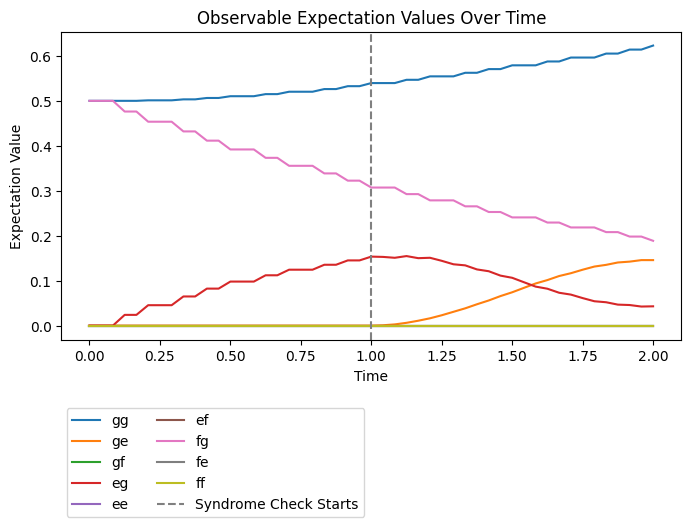

In [44]:
# Define time ranges for delay and iSWAP
delay_range = np.linspace(0, 1, 25)  # Delay phase
iswap_range = np.linspace(0, 1, 25)  # Syndrome check phase
combined_time = np.concatenate((delay_range, delay_range[-1] + iswap_range))

# Run the full experiment
full_experiment_results = simulate_full_experiment(
    initial_state, delay_range, iswap_range
)

# Plot the results
plot_full_experiment(
    observables, full_experiment_results, combined_time, delay_range[-1]
)